In [39]:
# Import statements

import os
import numpy as np
from scipy.spatial import distance_matrix
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.spatial.distance import cdist
import pandas as pd

In [40]:
# Functions

# Ensure coordinates are in the correct shape (2D array of shape (n_points, 3))
def load_swc_coordinates(file_path):
    # Assuming this function loads the SWC data and returns it as a numpy array (n_points, 3)
    # The last column might be radius, so we take only the first three columns (x, y, z)
    data = np.loadtxt(file_path)
    return data[:, 2:5]  # Return only the x, y, z columns

def average_bidirectional_distance(A, B):
    # Ensure that A and B are 2D arrays
    A = np.array(A)
    B = np.array(B)
    
    # Check if the coordinates are 2D arrays
    if A.ndim != 2 or B.ndim != 2:
        raise ValueError("Both A and B should be 2D arrays representing the coordinates (n_points, 3).")

    # Compute pairwise distance matrix between A and B
    dists = cdist(A, B)
    
    # Average distances A->B and B->A
    avg_a_to_b = np.mean(np.min(dists, axis=1))  # Minimum distance for each point in A to closest point in B
    avg_b_to_a = np.mean(np.min(dists, axis=0))  # Minimum distance for each point in B to closest point in A
    
    return (avg_a_to_b + avg_b_to_a) / 2

def compute_pairwise_distances(swc_folder):
    swc_files = glob.glob(os.path.join(swc_folder, '*.swc'))
    pairwise_means = []
    
    # Assuming you have a function to compute pairwise distances (e.g., `average_bidirectional_distance`)
    for i, file_i in enumerate(swc_files):
        coords_i = load_swc_coordinates(file_i)
        for j, file_j in enumerate(swc_files[i + 1:], start=i + 1):
            coords_j = load_swc_coordinates(file_j)
            pairwise_means.append(average_bidirectional_distance(coords_i, coords_j))
    
    return pairwise_means


In [41]:
## Data wrangling for GABA skeletons

# Load and compute pairwise distances for GABA left and right datasets affine+rigid and diffeomorphic
left_GABA_affine_folder = 'data/skeletons/skeletons_affine+rigid/GABA/left/'
right_GABA_affine_folder = 'data/skeletons/skeletons_affine+rigid/GABA/right/'

left_GABA_affine_pairwise_means = compute_pairwise_distances(left_GABA_affine_folder)
right_GABA_affine_pairwise_means = compute_pairwise_distances(right_GABA_affine_folder)

left_GABA_diffeo_folder = 'data/skeletons/skeletons_diffeomorphic/GABA/left/'
right_GABA_diffeo_folder = 'data/skeletons/skeletons_diffeomorphic/GABA/right/'

left_GABA_diffeo_pairwise_means = compute_pairwise_distances(left_GABA_diffeo_folder)
right_GABA_diffeo_pairwise_means = compute_pairwise_distances(right_GABA_diffeo_folder)

# Calculate means and standard deviations
mean_GABA_affine_left = np.mean(left_GABA_affine_pairwise_means)
std_GABA_affine_left = np.std(left_GABA_affine_pairwise_means)

mean_GABA_affine_right = np.mean(right_GABA_affine_pairwise_means)
std_GABA_affine_right = np.std(right_GABA_affine_pairwise_means)

mean_GABA_diffeo_left = np.mean(left_GABA_diffeo_pairwise_means)
std_GABA_diffeo_left = np.std(left_GABA_diffeo_pairwise_means)

mean_GABA_diffeo_right = np.mean(right_GABA_diffeo_pairwise_means)
std_GABA_diffeo_right = np.std(right_GABA_diffeo_pairwise_means)

# Create a DataFrame to combine both sets of data
df_GABA_affine_left = pd.DataFrame({
    "pairwise_mean": left_GABA_affine_pairwise_means,
    "set": "Left"
})

df_GABA_affine_right = pd.DataFrame({
    "pairwise_mean": right_GABA_affine_pairwise_means,
    "set": "Right"
})

df_GABA_affine = pd.concat([df_GABA_affine_left, df_GABA_affine_right], ignore_index=True)

df_GABA_diffeo_left = pd.DataFrame({
    "pairwise_mean": left_GABA_diffeo_pairwise_means,
    "set": "Left"
})

df_GABA_diffeo_right = pd.DataFrame({
    "pairwise_mean": right_GABA_diffeo_pairwise_means,
    "set": "Right"
})

df_GABA_diffeo = pd.concat([df_GABA_diffeo_left, df_GABA_diffeo_right], ignore_index=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Registration
affine+rigid     10.803284
diffeomorphic     3.427410
Name: pairwise_mean, dtype: float64
Registration
affine+rigid     6.050937
diffeomorphic    1.733904
Name: pairwise_mean, dtype: float64


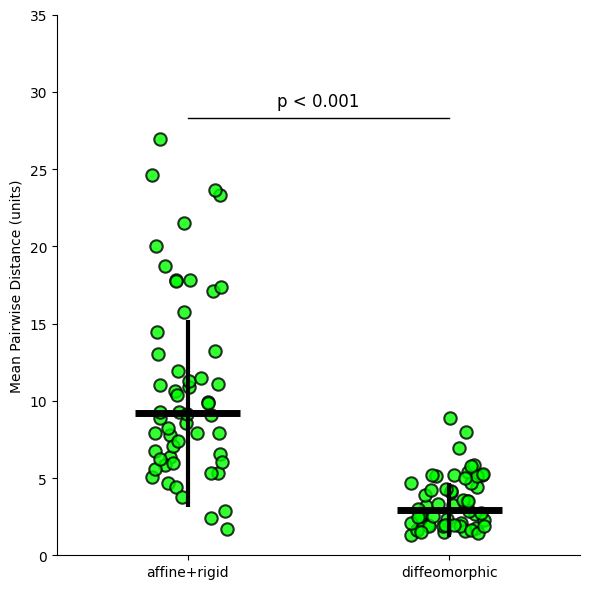

In [42]:
## Generating Figure 3G -- GABA skeleton distance

# make single df
df_GABA_affine['Registration'] = 'affine+rigid'
df_GABA_diffeo['Registration'] = 'diffeomorphic'
df_GABA = pd.concat([df_GABA_affine, df_GABA_diffeo], ignore_index=True)

# add jitter
np.random.seed(321)
df_GABA['x_jitter'] = df_GABA['Registration'].map({
    'affine+rigid': lambda: 0 + np.random.uniform(-0.15, 0.15),
    'diffeomorphic': lambda: 1 + np.random.uniform(-0.15, 0.15)
}).apply(lambda f: f())

# Compute group means and stds
means = df_GABA.groupby('Registration')['pairwise_mean'].mean()
medians = df_GABA.groupby('Registration')['pairwise_mean'].median()

stds = df_GABA.groupby('Registration')['pairwise_mean'].std()

print(means)
print(stds)

from scipy.stats import ttest_ind

# Extract values
affine_vals = df_GABA[df_GABA['Registration'] == 'affine+rigid']['pairwise_mean']
diffeo_vals = df_GABA[df_GABA['Registration'] == 'diffeomorphic']['pairwise_mean']

# Two-sample t-test (Welch’s by default: unequal variances)
t_stat, p_val = ttest_ind(affine_vals, diffeo_vals, equal_var=False)


# Plot
plt.figure(figsize=(6, 6))

# Custom colors per registration type
colors = {'affine+rigid': 'lime', 'diffeomorphic': 'lime'}

# Plot each group separately
for i, reg in enumerate(['affine+rigid', 'diffeomorphic']):
    subset = df_GABA[df_GABA['Registration'] == reg]
    plt.scatter(
        subset['x_jitter'], subset['pairwise_mean'],
        facecolors=colors[reg], edgecolors='black', linewidth=1.5, alpha=0.8, s=80
    )
    # Mean line
    med_val = medians.get(reg, np.nan) if hasattr(medians,'get') else (medians[reg] if reg in medians.index else np.nan)
    std_val = stds.get(reg, np.nan) if hasattr(stds,'get') else (stds[reg] if reg in stds.index else np.nan)
    if not np.isnan(med_val):
        plt.hlines(med_val, xmin=i - 0.2, xmax=i + 0.2, colors='black', linewidth=5)
    # Std error bars
    # errorbar replaced with safe lookup
    if not np.isnan(std_val):
        plt.errorbar(x=i, y=med_val, yerr=std_val, fmt='none',
                 ecolor='black', linewidth=3, capsize=0)


# Annotate p-value
max_val = df_GABA['pairwise_mean'].max()
y_annotation = max_val + (0.05 * max_val)
plt.plot([0, 1], [y_annotation]*2, color='black', linewidth=1)
plt.text(0.5, y_annotation + 0.02 * max_val,
         f"p = {p_val:.3g}" if p_val >= 0.001 else "p < 0.001",
         ha='center', va='bottom', fontsize=12)

# X-axis labels
plt.xticks([0, 1], ['affine+rigid', 'diffeomorphic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0,35)
plt.ylabel("Mean Pairwise Distance (units)")


# Keep only x and y axis 
sns.despine(top=True, right=True)

plt.tight_layout()

plt.savefig("figures/Fig3E_GABAskeletondistance.png", format='png', dpi=600)
plt.savefig("figures/Fig3E_GABAskeletondistance.eps", format='eps', dpi=300)

# headless: plt.show() removed


In [43]:
# Data wrangling for inotocin skeletons 

# Load and compute pairwise distances for inotocin left and right datasets (affine+rigid and diffeomorphic)
left_inotocin_affine_folder = 'data/skeletons/skeletons_affine+rigid/inotocin/left/'
right_inotocin_affine_folder = 'data/skeletons/skeletons_affine+rigid/inotocin/right/'

left_inotocin_affine_pairwise_means = compute_pairwise_distances(left_inotocin_affine_folder)
right_inotocin_affine_pairwise_means = compute_pairwise_distances(right_inotocin_affine_folder)

left_inotocin_diffeo_folder = 'data/skeletons/skeletons_diffeomorphic/inotocin/left/'
right_inotocin_diffeo_folder = 'data/skeletons/skeletons_diffeomorphic/inotocin/right/'

left_inotocin_diffeo_pairwise_means = compute_pairwise_distances(left_inotocin_diffeo_folder)
right_inotocin_diffeo_pairwise_means = compute_pairwise_distances(right_inotocin_diffeo_folder)

# Calculate means and standard deviations
mean_inotocin_affine_left = np.mean(left_inotocin_affine_pairwise_means)
std_inotocin_affine_left = np.std(left_inotocin_affine_pairwise_means)

mean_inotocin_affine_right = np.mean(right_inotocin_affine_pairwise_means)
std_inotocin_affine_right = np.std(right_inotocin_affine_pairwise_means)

mean_inotocin_diffeo_left = np.mean(left_inotocin_diffeo_pairwise_means)
std_inotocin_diffeo_left = np.std(left_inotocin_diffeo_pairwise_means)

mean_inotocin_diffeo_right = np.mean(right_inotocin_diffeo_pairwise_means)
std_inotocin_diffeo_right = np.std(right_inotocin_diffeo_pairwise_means)

# Create a DataFrame to combine both sets of data
df_inotocin_affine_left = pd.DataFrame({
    "pairwise_mean": left_inotocin_affine_pairwise_means,
    "set": "Left"
})

df_inotocin_affine_right = pd.DataFrame({
    "pairwise_mean": right_inotocin_affine_pairwise_means,
    "set": "Right"
})

df_inotocin_affine = pd.concat([df_inotocin_affine_left, df_inotocin_affine_right], ignore_index=True)

df_inotocin_diffeo_left = pd.DataFrame({
    "pairwise_mean": left_inotocin_diffeo_pairwise_means,
    "set": "Left"
})

df_inotocin_diffeo_right = pd.DataFrame({
    "pairwise_mean": right_inotocin_diffeo_pairwise_means,
    "set": "Right"
})

df_inotocin_diffeo = pd.concat([df_inotocin_diffeo_left, df_inotocin_diffeo_right], ignore_index=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Registration
affine+rigid     44.192629
diffeomorphic     5.395328
Name: pairwise_mean, dtype: float64
Registration
affine+rigid     25.790272
diffeomorphic     2.659843
Name: pairwise_mean, dtype: float64


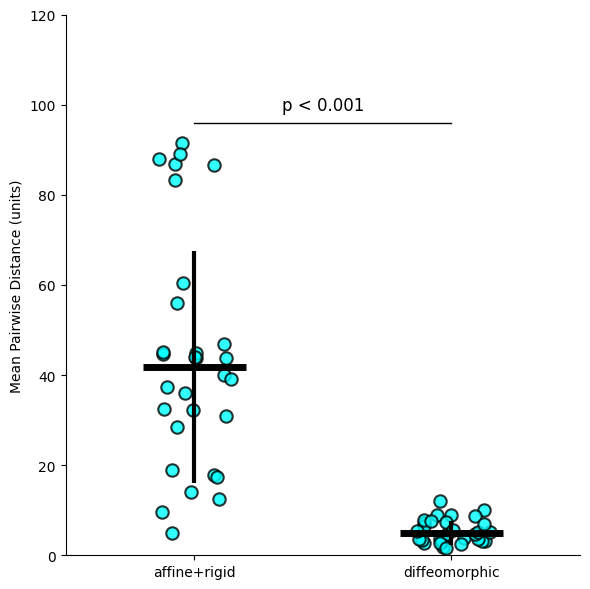

In [44]:
# Generating Fig 3F -- inotocin skeleton distance 

# Make single DataFrame
df_inotocin_affine['Registration'] = 'affine+rigid'
df_inotocin_diffeo['Registration'] = 'diffeomorphic'

df_inotocin = pd.concat([df_inotocin_affine, df_inotocin_diffeo], ignore_index=True)

# Add jitter
np.random.seed(321)
df_inotocin['x_jitter'] = df_inotocin['Registration'].map({
    'affine+rigid': lambda: 0 + np.random.uniform(-0.15, 0.15),
    'diffeomorphic': lambda: 1 + np.random.uniform(-0.15, 0.15)
}).apply(lambda f: f())

# Compute group means and stds
means = df_inotocin.groupby('Registration')['pairwise_mean'].mean()
medians = df_inotocin.groupby('Registration')['pairwise_mean'].median()

stds = df_inotocin.groupby('Registration')['pairwise_mean'].std()

# Extract values for t-test
affine_vals = df_inotocin[df_inotocin['Registration'] == 'affine+rigid']['pairwise_mean']
diffeo_vals = df_inotocin[df_inotocin['Registration'] == 'diffeomorphic']['pairwise_mean']

# Two-sample t-test
t_stat, p_val = ttest_ind(affine_vals, diffeo_vals, equal_var=False)

print(means)
print(stds)

# Plot
plt.figure(figsize=(6, 6))
colors = {'affine+rigid': 'cyan', 'diffeomorphic': 'cyan'}

# Plot each group
for i, reg in enumerate(['affine+rigid', 'diffeomorphic']):
    subset = df_inotocin[df_inotocin['Registration'] == reg]
    plt.scatter(
        subset['x_jitter'], subset['pairwise_mean'],
        facecolors=colors[reg], edgecolors='black', linewidth=1.5, alpha=0.8, s=80
    )
    # Mean line
    med_val = medians.get(reg, np.nan) if hasattr(medians,'get') else (medians[reg] if reg in medians.index else np.nan)
    std_val = stds.get(reg, np.nan) if hasattr(stds,'get') else (stds[reg] if reg in stds.index else np.nan)
    if not np.isnan(med_val):
        plt.hlines(med_val, xmin=i - 0.2, xmax=i + 0.2, colors='black', linewidth=5)
    # Std error bars
    # errorbar replaced with safe lookup
    if not np.isnan(std_val):
        plt.errorbar(x=i, y=med_val, yerr=std_val, fmt='none',
                 ecolor='black', linewidth=3, capsize=0)

# Annotate p-value
max_val = df_inotocin['pairwise_mean'].max()
y_annotation = max_val + (0.05 * max_val)
plt.plot([0, 1], [y_annotation]*2, color='black', linewidth=1)
plt.text(0.5, y_annotation + 0.02 * max_val,
         f"p = {p_val:.3g}" if p_val >= 0.001 else "p < 0.001",
         ha='center', va='bottom', fontsize=12)

# Labels and limits
plt.xticks([0, 1], ['affine+rigid', 'diffeomorphic'])
plt.xlim(-0.5, 1.5)
plt.ylabel("Mean Pairwise Distance (units)")
plt.ylim(0, 120)


# Keep only x and y axis 
sns.despine(top=True, right=True)

plt.tight_layout()

# Save plot
plt.savefig("figures/Fig3F_inotocinskeletondistance.png", format='png', dpi=600)
plt.savefig("figures/Fig3F_inotocinskeletondistance.eps", format='eps', dpi=300)

# headless: plt.show() removed
